# Loan Amortization Calculator

## Introduction
This notebook provides a detailed analysis of loan amortization. It focuses on calculating periodic payment amounts for various loan scenarios using different payment frequencies.

## Library Imports
The following libraries are used in this notebook:
- `datetime`: For handling date and time.
- `pandas`: For data manipulation and analysis.
- `matplotlib.pyplot`: For creating static, animated, and interactive visualizations.
- `enum`: For creating enumerations, which are a set of symbolic names bound to unique, constant values.

In [49]:
from datetime import date
import pandas as pd
import matplotlib.pyplot as plt
from enum import Enum

## Class and Function Definitions

### PaymentFrequency Class
This class enumerates various payment frequencies, such as daily, weekly, and monthly, to be used in loan calculations.

In [50]:
class PaymentFrequency(Enum):
    DAILY = 365
    BIWEEKLY = 104
    WEEKLY = 52
    SEMIMONTHLY = 24
    MONTHLY = 12
    QUARTERLY = 4
    SEMIYEARLY = 2
    YEARLY = 1

### Loan Payment Calculation Function
`calculate_payment_amount` is a function designed to calculate the periodic payment amount for a loan. This function takes into account the principal, interest rate, payment period, and frequency.

In [51]:
def calculate_payment_amount(
    principal: float, 
    interest_rate: float, 
    period: int, 
    payment_frequency: PaymentFrequency = PaymentFrequency.MONTHLY
) -> float:
    """
    Calculate the periodic payment amount for a loan.

    This function computes the amount to be paid per period on a loan, based on the loan's principal,
    the annual interest rate, the total number of payment periods, and the payment frequency. The calculation
    assumes a fixed rate for the duration of the loan.

    Parameters:
    - loan_amount (float): The initial amount of the loan.
    - interest_rate (float): The annual interest rate as a decimal (e.g., 0.05 for 5%).
    - period (int): The total number of payment periods for the loan.
    - payment_frequency (PaymentFrequency, optional): Frequency of payments (e.g., monthly, semi-monthly).
      Defaults to PaymentFrequency.MONTHLY.

    Returns:
    - float: The calculated periodic payment amount.

    Examples:
    - Calculate monthly payments for a $500,000 loan with a 5% annual interest rate over 30 years (360 months):
      >>> calculate_amortization_amount(500000, 0.05, 360)
      # Example return value

    - Calculate semi-monthly payments for the same loan:
      >>> calculate_amortization_amount(500000, 0.05, 360, PaymentFrequency.SEMIMONTHLY)
      # Example return value
    """
    adjusted_interest = interest_rate / payment_frequency.value
    x = (1 + adjusted_interest) ** period
    
    return round(principal * (adjusted_interest * x) / (x - 1), 2)

In [52]:
PRINCIPAL = 359200
INTEREST_RATE = 0.0625
PERIOD = 360

In [53]:
amount = calculate_payment_amount(LOAN_AMOUNT, INTEREST_RATE, PERIOD)
amount

2211.66

In [78]:
class Loan:
    """Loan class to calculate amortization schedule, optionally with additional payments."""

    def __init__(self, principal, annual_interest_rate, loan_term_years, start_date):
        self.principal = principal
        self.annual_interest_rate = annual_interest_rate
        self.loan_term_years = loan_term_years
        self.monthly_interest_rate = annual_interest_rate / 12
        self.number_of_payments = loan_term_years * 12
        self.start_date = start_date
        self.additional_payments = {}
        self.amortization_schedule = pd.DataFrame()

    def calculate_monthly_payment(self):
        # Calculate using the existing function that exists outside of the class
        return calculate_payment_amount(
            self.principal,
            self.annual_interest_rate,
            self.number_of_payments,
            PaymentFrequency.MONTHLY  # Assuming monthly payments
        )

    def add_additional_payment(self, payment_date, amount):
        """Add an additional payment."""
        self.additional_payments[payment_date] = self.additional_payments.get(payment_date, 0) + amount

    def generate_amortization_schedule(self):
        monthly_payment = self.calculate_monthly_payment()
        balance = self.principal
        total_interest = 0
        schedule = []

        current_date = self.start_date
        for month in range(self.number_of_payments):
            if month > 0:
                current_date = date(current_date.year + (current_date.month // 12), current_date.month % 12 + 1, 1)
            
            additional_payment = self.additional_payments.get(current_date, 0)
            balance -= additional_payment

            interest_payment = balance * self.monthly_interest_rate
            principal_payment = min(monthly_payment - interest_payment, balance)
            balance -= principal_payment
            total_interest += interest_payment
            
            active = balance > 0  # Determine if the loan is still active
            
            schedule.append((current_date, monthly_payment if active else 0,
                             principal_payment if active else 0, interest_payment if active else 0,
                             additional_payment if active else 0,
                             total_interest if balance > 0 else total_interest,
                             balance if active else 0))

            self.total_interest_paid = total_interest  # Update total_interest_paid here

            if balance <= 0:
                break

        self.amortization_schedule = pd.DataFrame(schedule, columns=['Date', 'Payment', 'Principal', 'Interest', 'Additional Payment', 'Total Interest', 'Balance'])

    def plot_amortization_schedule(self):
        plt.figure(figsize=(15, 7))
        plt.plot(self.amortization_schedule['Date'], self.amortization_schedule['Principal'], label='Principal')
        plt.plot(self.amortization_schedule['Date'], self.amortization_schedule['Interest'], label='Interest')
        plt.title('Amortization Schedule')
        plt.xlabel('Date')
        plt.ylabel('Amount ($)')
        plt.legend()
        plt.grid(True)
        plt.show()

## Calculation and Analysis

Here, we set the principal amount, interest rate, and period for a sample loan and use the `calculate_payment_amount` function to determine the periodic payment amount. This section can be extended to include various scenarios and comparative analyses.

In [79]:
# Instantiate the original loan 
original_loan = Loan(principal=LOAN_AMOUNT, annual_interest_rate=INTEREST_RATE, loan_term_years=30, start_date=date(2023, 11, 1))
original_loan.generate_amortization_schedule()

In [80]:
# Instantiate the modified loan that would have the same set up, but would get additional payments
modified_loan = Loan(principal=LOAN_AMOUNT, annual_interest_rate=INTEREST_RATE, loan_term_years=30, start_date=date(2023, 11, 1))
modified_loan.add_additional_payment(date(2023, 11, 1), 4000) 
modified_loan.add_additional_payment(date(2023, 12, 1), 4000) 
modified_loan.add_additional_payment(date(2024, 1, 1), 5000)  
modified_loan.generate_amortization_schedule()

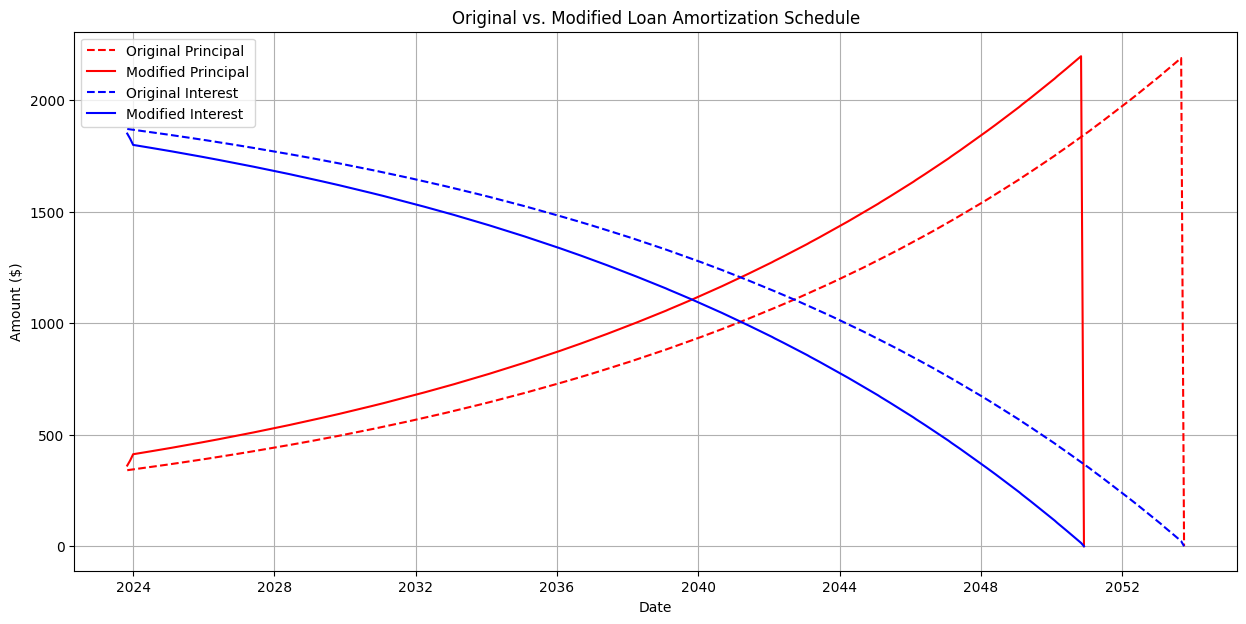

In [81]:
# Plotting both schedules for comparison
plt.figure(figsize=(15, 7))
plt.plot(original_loan.amortization_schedule['Date'], original_loan.amortization_schedule['Principal'], 'r--', label='Original Principal')
plt.plot(modified_loan.amortization_schedule['Date'], modified_loan.amortization_schedule['Principal'], 'r-', label='Modified Principal')
plt.plot(original_loan.amortization_schedule['Date'], original_loan.amortization_schedule['Interest'], 'b--', label='Original Interest')
plt.plot(modified_loan.amortization_schedule['Date'], modified_loan.amortization_schedule['Interest'], 'b-', label='Modified Interest')
plt.title('Original vs. Modified Loan Amortization Schedule')
plt.xlabel('Date')
plt.ylabel('Amount ($)')
plt.legend()
plt.grid(True)
plt.show()

In [82]:
original_loan.amortization_schedule

,Date,Payment,Principal,Interest,Additional Payment,Total Interest,Balance
0,2023-11-01,2211.66,340.826667,1870.833333,0,1870.833333,358859.173333
1,2023-12-01,2211.66,342.601806,1869.058194,0,3739.891528,358516.571528
2,2024-01-01,2211.66,344.386190,1867.273810,0,5607.165338,358172.185338
3,2024-02-01,2211.66,346.179868,1865.480132,0,7472.645470,357826.005470
4,2024-03-01,2211.66,347.982888,1863.677112,0,9336.322582,357478.022582
...,...,...,...,...,...,...,...
355,2053-06-01,2211.66,2154.974200,56.685800,0,436879.659309,8728.699309
356,2053-07-01,2211.66,2166.198024,45.461976,0,436925.121285,6562.501285
357,2053-08-01,2211.66,2177.480306,34.179694,0,436959.300979,4385.020979
358,2053-09-01,2211.66,2188.821349,22.838651,0,436982.139630,2196.199630


In [83]:
modified_loan.amortization_schedule

,Date,Payment,Principal,Interest,Additional Payment,Total Interest,Balance
0,2023-11-01,2211.66,361.660000,1850.000000,4000,1850.000000,354838.340000
1,2023-12-01,2211.66,384.376979,1827.283021,4000,3677.283021,350453.963021
2,2024-01-01,2211.66,412.420609,1799.239391,5000,5476.522412,345041.542412
3,2024-02-01,2211.66,414.568633,1797.091367,0,7273.613778,344626.973778
4,2024-03-01,2211.66,416.727845,1794.932155,0,9068.545933,344210.245933
...,...,...,...,...,...,...,...
321,2050-08-01,2211.66,2162.867807,48.792193,0,373159.753183,7205.233183
322,2050-09-01,2211.66,2174.132744,37.527256,0,373197.280439,5031.100439
323,2050-10-01,2211.66,2185.456352,26.203648,0,373223.484087,2845.644087
324,2050-11-01,2211.66,2196.838937,14.821063,0,373238.305150,648.805150


In [91]:
def compare_loans_and_calculate_annual_benefit(original_loan: Loan, modified_loan: Loan):
    """
    Compares two loan objects to determine the impact of additional payments.

    Args:
    original_loan (Loan): The original loan object without additional payments.
    modified_loan (Loan): The modified loan object with additional payments.

    Returns:
    None: Prints out the comparison results.
    """
    # Number of months of payments saved
    months_saved = len(original_loan.amortization_schedule) - len(modified_loan.amortization_schedule)

    # Total interest saved
    interest_saved = original_loan.total_interest_paid - modified_loan.total_interest_paid

    # Additional comparison if both loans have additional payments
    if original_loan.additional_payments and modified_loan.additional_payments:
        # Compare the additional payments impact
        original_additional_payment_total = sum(original_loan.additional_payments.values())
        modified_additional_payment_total = sum(modified_loan.additional_payments.values())
        additional_payment_difference = modified_additional_payment_total - original_additional_payment_total

        print("\nAdditional Payment Impact Comparison:")
        print(f"Total additional payment in original loan: ${original_additional_payment_total:.2f}")
        print(f"Total additional payment in modified loan: ${modified_additional_payment_total:.2f}")
        print(f"Difference in additional payments: ${additional_payment_difference:.2f}")
        
    # Total interest saved
    interest_saved = original_loan.total_interest_paid - modified_loan.total_interest_paid
    
    # Total additional payment made
    total_additional_payment = sum(modified_loan.additional_payments.values())

    # Per year benefit in dollars
    per_year_benefit = interest_saved / original_loan.loan_term_years

    # Calculate ROI
    roi = ((interest_saved / total_additional_payment) - 1) * 100

    # Time period over which the interest is saved
    years_saved = (len(original_loan.amortization_schedule) - len(modified_loan.amortization_schedule)) / 12

    # Calculate annualized ROI
    annualized_roi = ((1 + roi / 100) ** (1 / years_saved) - 1) * 100 if years_saved > 0 else 0

    # Yearly return rate as a percentage of the additional payment
    yearly_return_percentage = (per_year_benefit / total_additional_payment) * 100 if total_additional_payment else 0

    print("Loan Comparison Results:")
    print(f"Months of payments saved: {months_saved} months")
    print(f"Total Interest Saved: ${interest_saved:.2f}")
    print(f"Total Additional Payment: ${total_additional_payment:.2f}")
    print(f"ROI: {roi:.2f}%")
    print(f"Annualized ROI: {annualized_roi:.2f}%")
    print(f"Annual Benefit: ${per_year_benefit:.2f}")
    print(f"Yearly Return Percentage: {yearly_return_percentage:.2f}%")

# Example Usage
compare_loans_and_calculate_annual_benefit(original_loan, modified_loan)

Loan Comparison Results:
Months of payments saved: 34 months
Total Interest Saved: $63751.89
Total Additional Payment: $13000.00
ROI: 390.40%
Annualized ROI: 75.28%
Annual Benefit: $2125.06
Yearly Return Percentage: 16.35%


## Conclusion and Further Exploration

This notebook provides a foundational analysis of loan payments. Further explorations could include varying interest rates, comparing different loan types, or visualizing the impact of payment frequency on the total interest paid over the loan's life.